In [1]:
import Libraries.fplibrary.exploration as e
import Libraries.fplibrary.feature_engineering as f
import Libraries.fplibrary.loading_data as l
import Libraries.fplibrary.preprocessing as p
import Libraries.fplibrary.model as m
import pandas as pd 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore")

Loading data

In [2]:
data_loader = l.DataLoader('data/apartments_pl_2023.csv')
train_data, test_data = data_loader.load_and_split_data()

# Merge train and test data for data exploration and pre-processing
train_data['is_train']=1
test_data['is_train']=0

all_data = pd.concat([train_data,test_data]).reset_index()

Data exploration

In [3]:
# Define plots class
plots = e.ExplorationPlots(all_data)

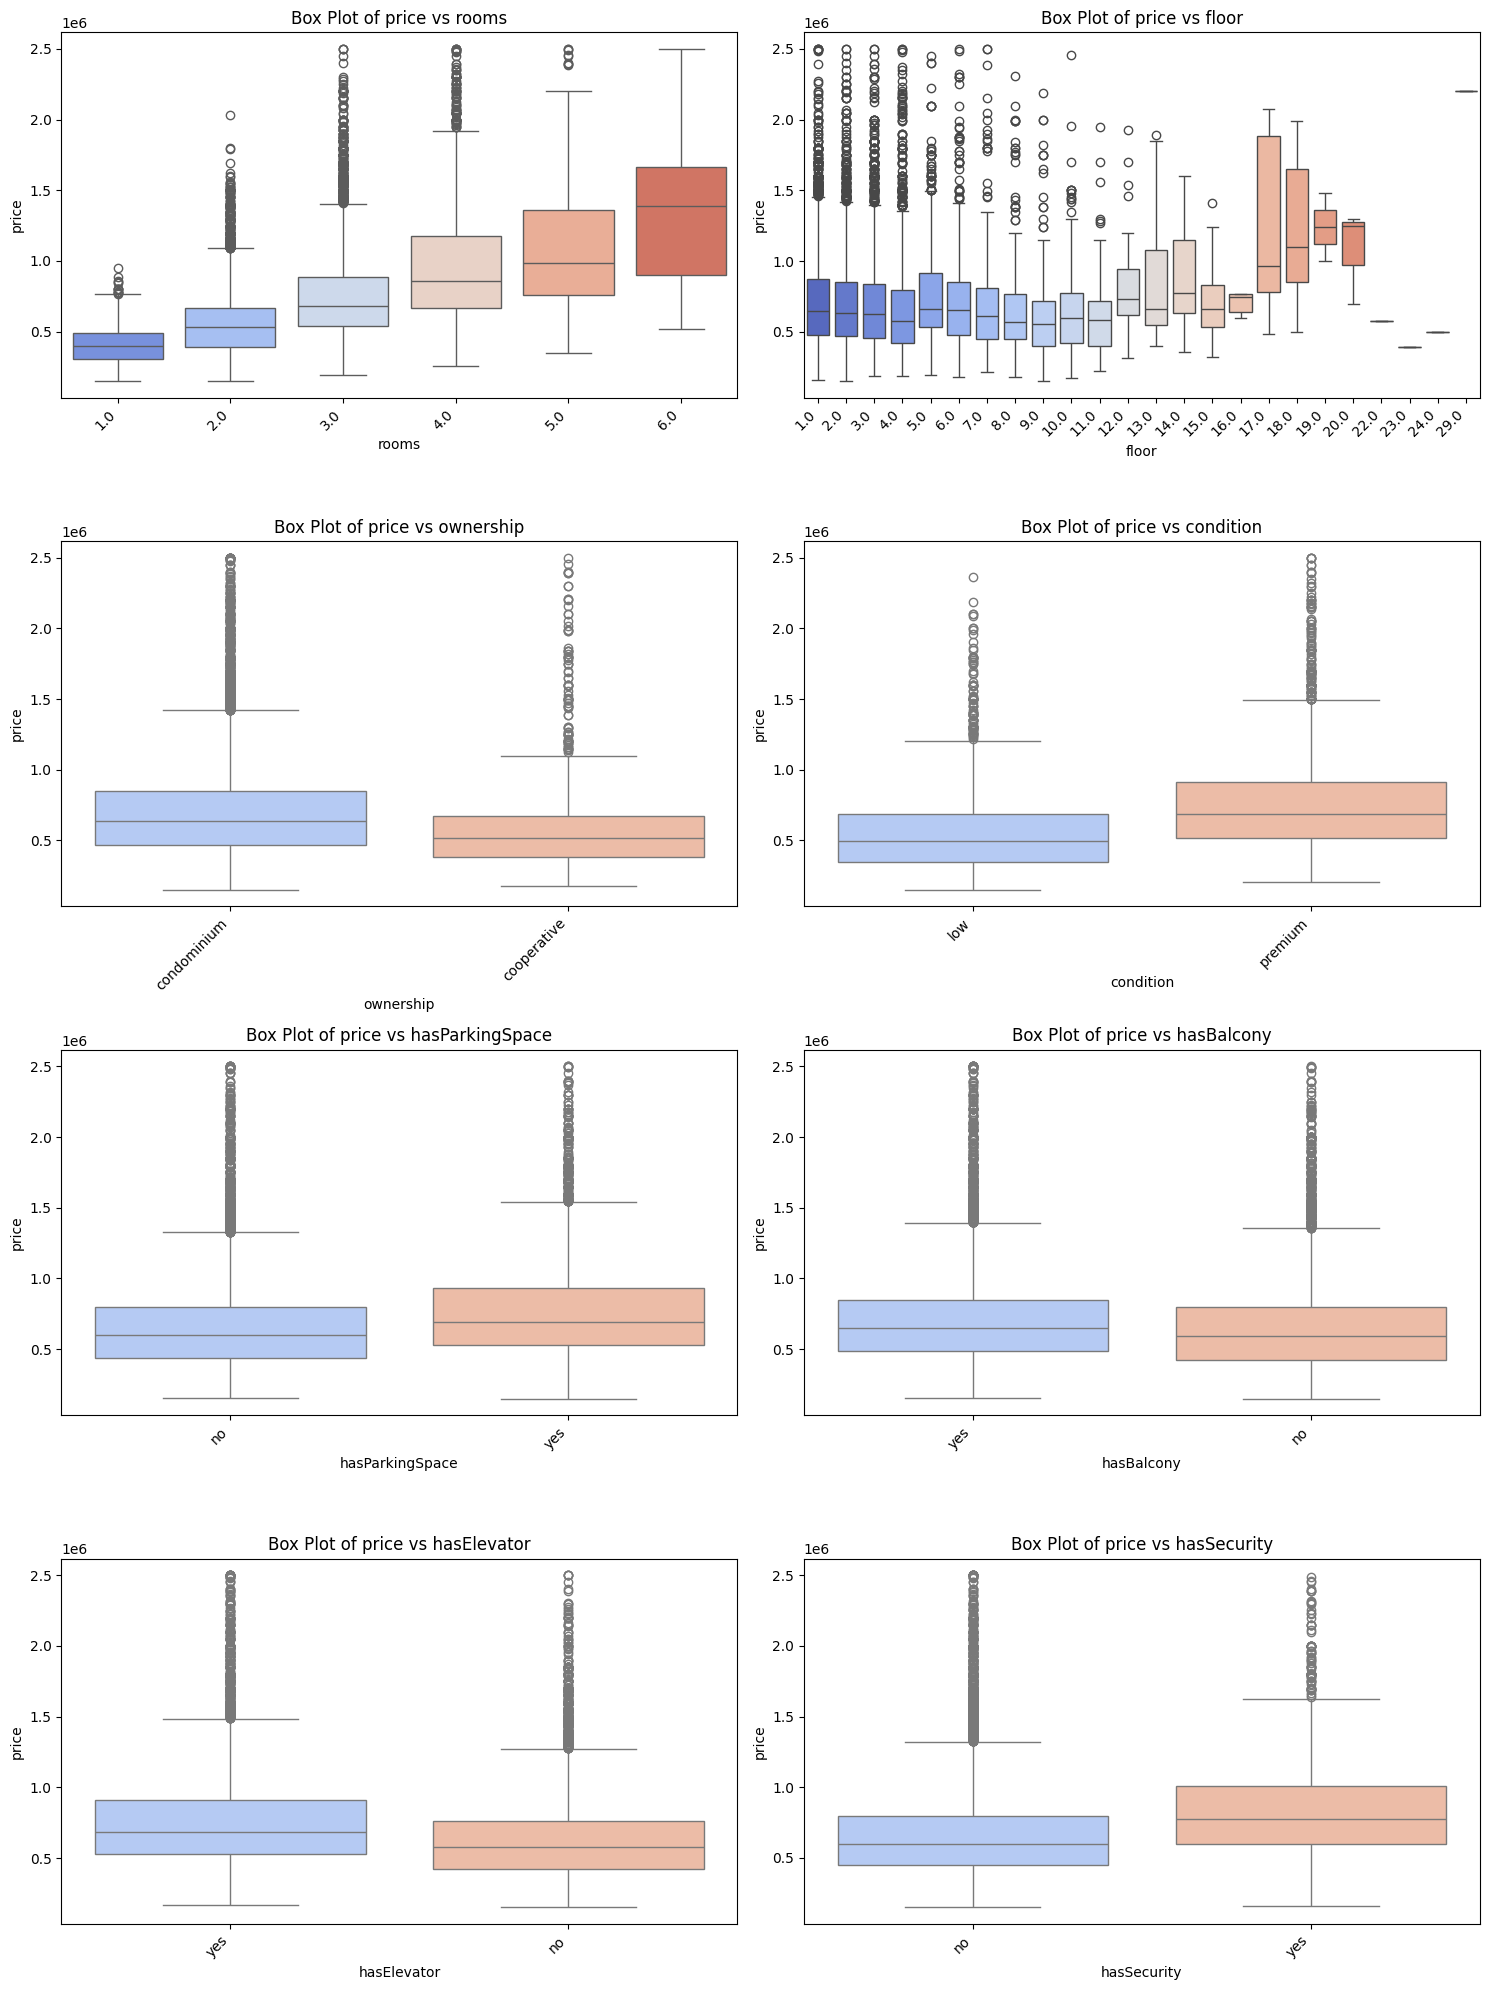

In [4]:
# Boxplots of price with categorical variables
plots.create_boxplot('price', ['rooms', 'floor', 'ownership', 'condition', 'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity'], n_rows=4, n_cols=2)

?? Flatten in function screws up when only producing 1 plot??

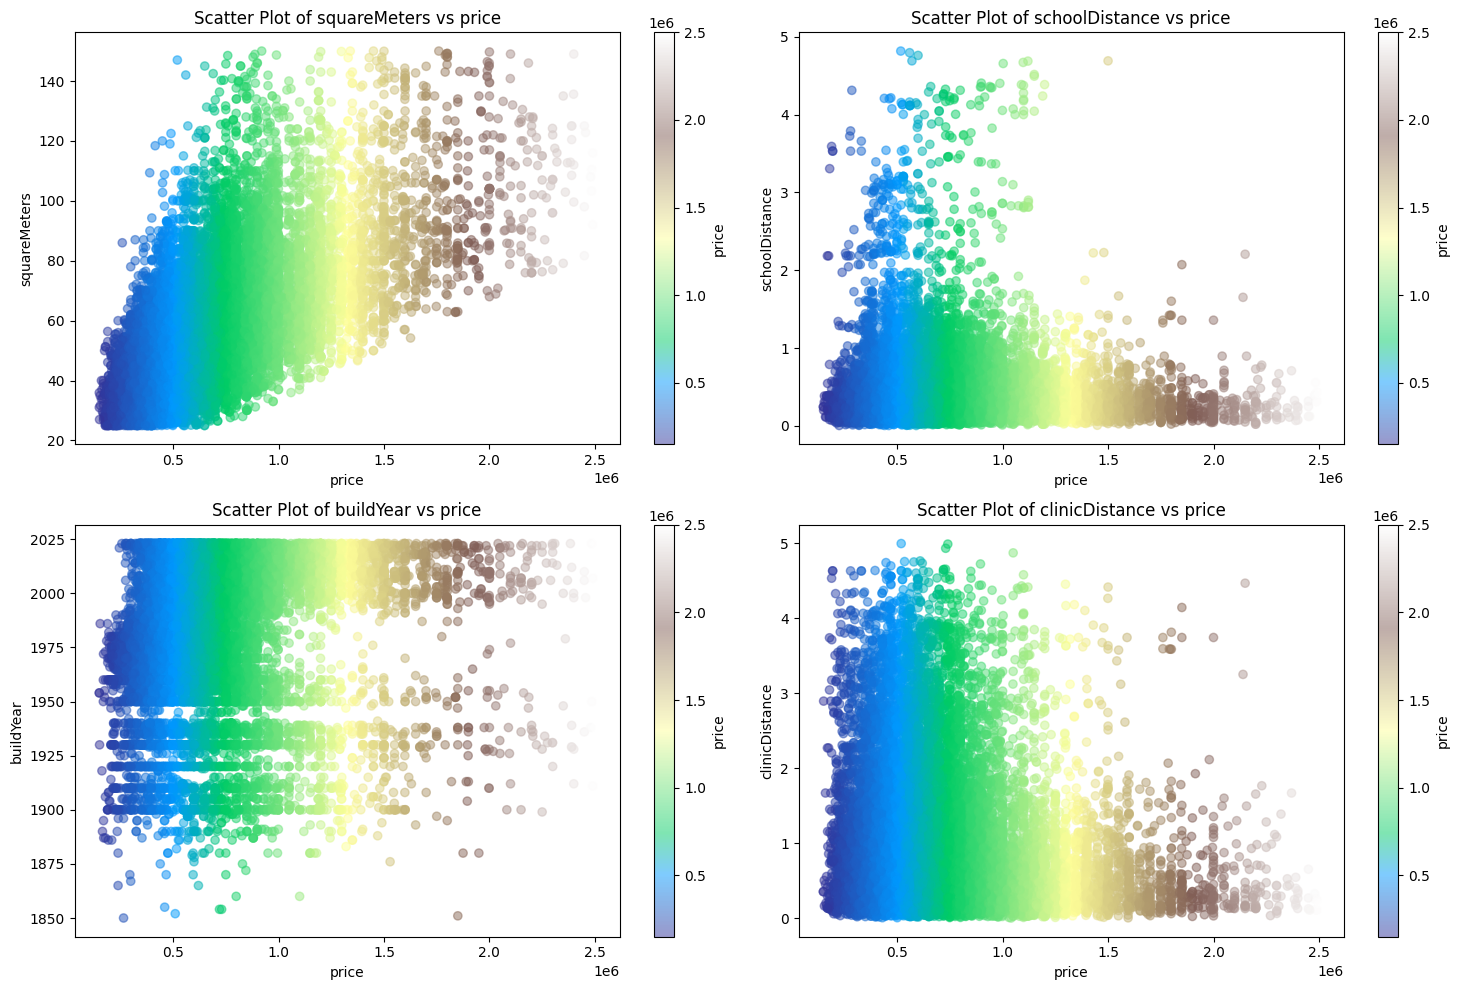

In [5]:
# Scatter plots
plots.create_scatter_plot([('price', 'squareMeters'), ('price', 'schoolDistance'), ('price', 'buildYear'), ('price', 'clinicDistance')], n_cols=2, n_rows=2)

??Again this screws up when only producing 1 plot??

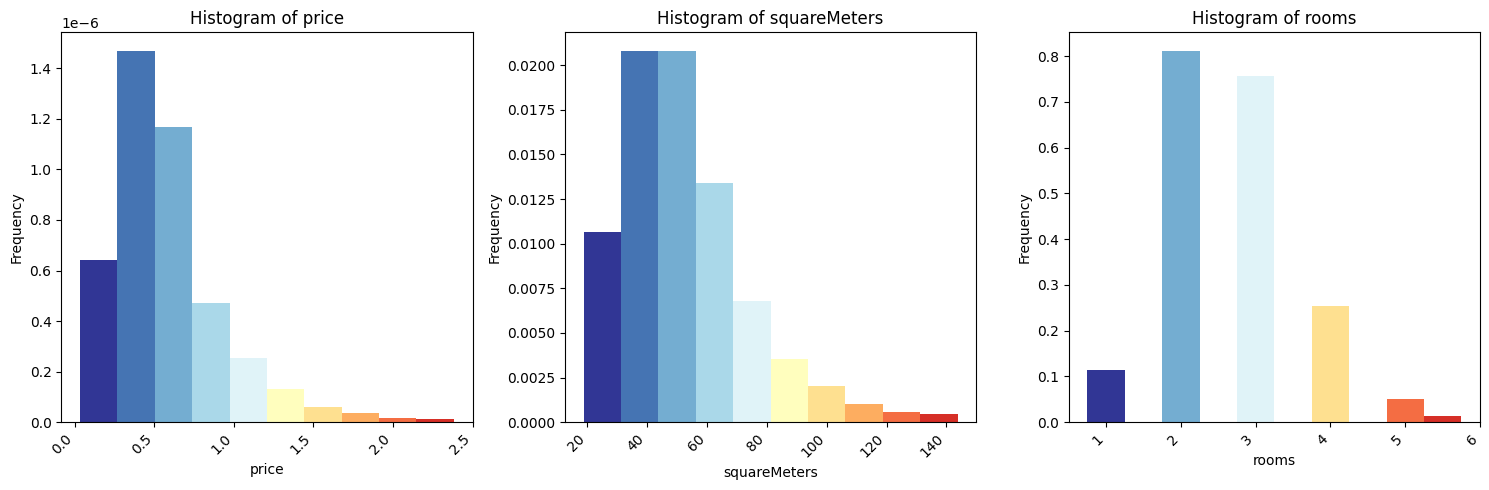

In [6]:
# Histograms
plots.create_histogram(['price', 'squareMeters', 'rooms'])

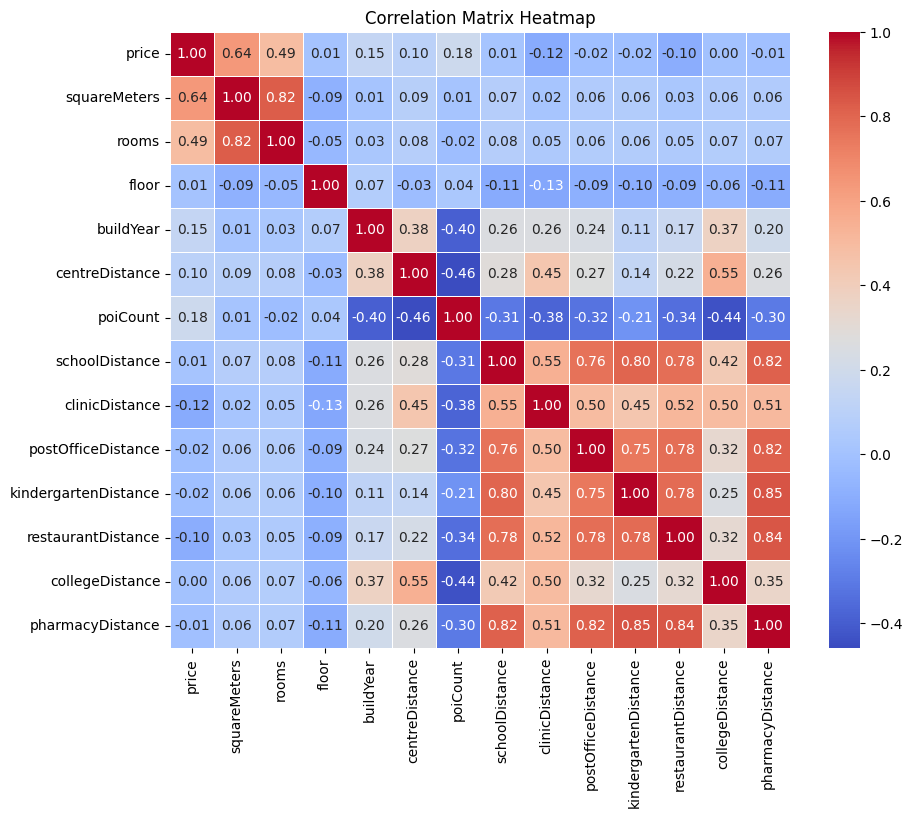

In [7]:
# Correlation matrix
corr = e.Correlation(all_data)
corr.visualize_data_correlation(['price', 'squareMeters', 'rooms', 'floor', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance'])

??Getting strange error in the below??

In [8]:
# Missing values analysis
miss = p.MissingValues(all_data)
missing_summary = miss.missing_values_summary()

In [9]:
all_data.isnull().sum()

index                       0
id                          0
city                        0
type                     4039
squareMeters                0
rooms                       0
floor                    3438
floorCount                262
buildYear                3271
latitude                    0
longitude                   0
centreDistance              0
poiCount                    0
schoolDistance             14
clinicDistance             88
postOfficeDistance         25
kindergartenDistance       13
restaurantDistance         58
collegeDistance           565
pharmacyDistance           27
ownership                   0
buildingMaterial         7387
condition               14344
hasParkingSpace             0
hasBalcony                  0
hasElevator               926
hasSecurity                 0
hasStorageRoom              0
price                       0
is_train                    0
dtype: int64

Data preprocessing

In [10]:
# Dealing with binary variables
encoder = f.Encoding(all_data)

cols_to_encode = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom']
mapping_dictionary = {'yes': 1, 'no': 0}

all_data = encoder.mapping(cols_to_encode, mapping_dictionary)

In [11]:
# Checking unique values in type
all_data['type'].unique()

array(['blockOfFlats', 'tenement', nan, 'apartmentBuilding'], dtype=object)

In [12]:
# Converting type to numerical so it can be imputed using KNN
encoder = f.Encoding(all_data)

mapping_dictionary = {'blockOfFlats': 1, 'tenement': 2, 'apartmentBuilding': 3}

all_data = encoder.mapping(['type'], mapping_dictionary)

In [13]:
# Dealing with missing values
miss_fill = p.MissingValues(all_data)

# Removing columns "condition" and "building_material" as there are so many missing values
miss_fill.remove_col(['condition', 'buildingMaterial'])

# Use KNN to impute all other missing values (arbitrarily use 5 neighbors) and return updated dataframe
all_data = miss_fill.impute_missing_knn(5)

In [14]:
# Check all missing values have been filled
all_data.isna().sum()

index                   0
id                      0
city                    0
type                    0
squareMeters            0
rooms                   0
floor                   0
floorCount              0
buildYear               0
latitude                0
longitude               0
centreDistance          0
poiCount                0
schoolDistance          0
clinicDistance          0
postOfficeDistance      0
kindergartenDistance    0
restaurantDistance      0
collegeDistance         0
pharmacyDistance        0
ownership               0
hasParkingSpace         0
hasBalcony              0
hasElevator             0
hasSecurity             0
hasStorageRoom          0
price                   0
is_train                0
dtype: int64

?? Type needs to be converted back to a categorical variable ??

We now have no missing values

Handle outliers

In [15]:
# Define outliers class
outliers = p.Outliers(all_data)

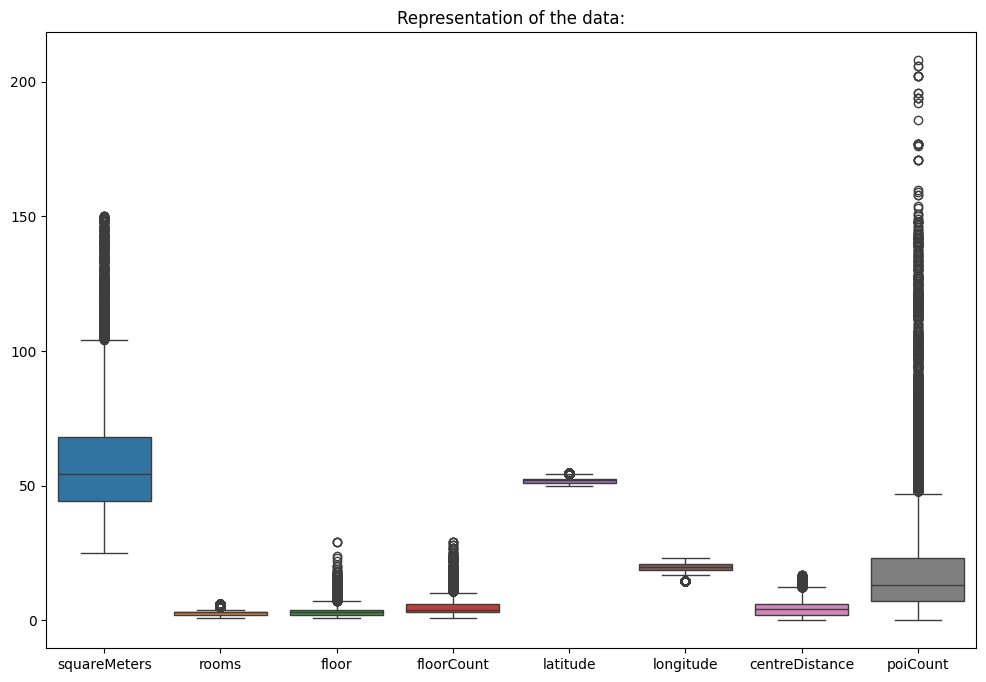

In [16]:
# Outlier handelling
columns_group_1 = ['squareMeters', 'rooms', 'floor', 'floorCount', 'latitude', 'longitude', 'centreDistance', 'poiCount']
# Plot outliers for the first group of numerical columns
outliers.plot_outliers(columns_group_1)

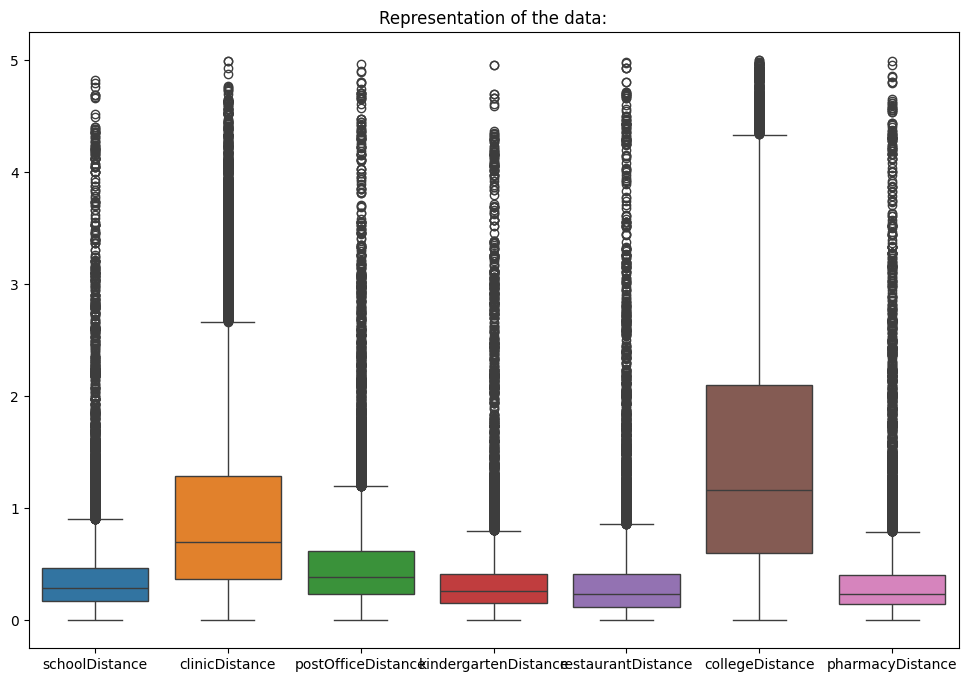

In [17]:
# Outlier handelling
columns_group_2 = ['schoolDistance',
       'clinicDistance', 'postOfficeDistance', 'kindergartenDistance',
       'restaurantDistance', 'collegeDistance', 'pharmacyDistance']
# Plot outliers for the second group of numerical columns
outliers.plot_outliers(columns_group_2)

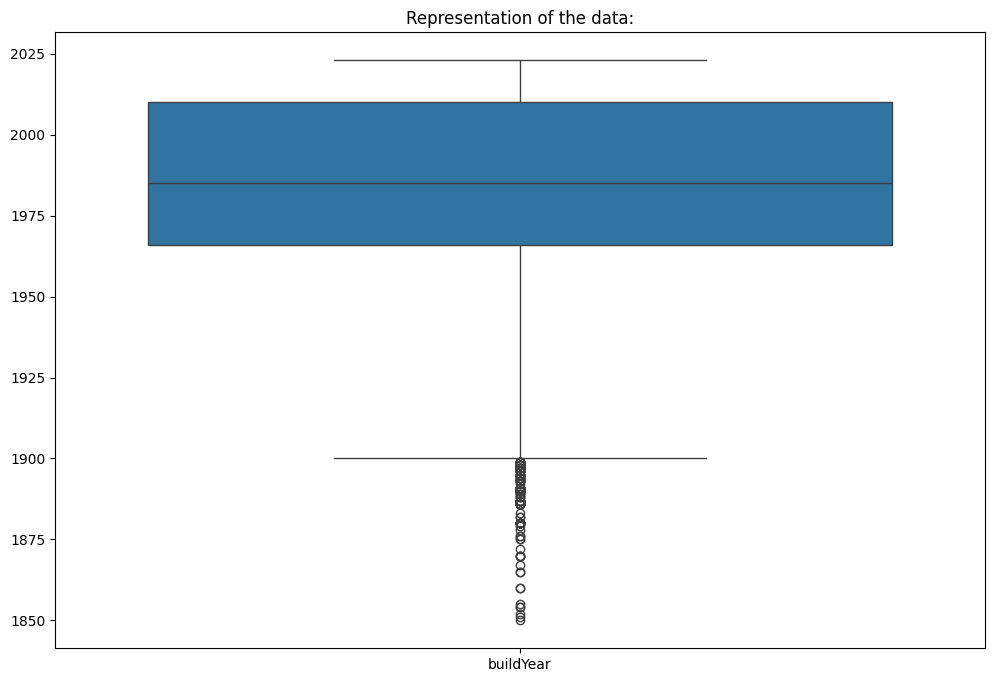

In [18]:
# Plot outliers for buildYear
outliers.plot_outliers(['buildYear'])

In [19]:
# Use standard deviation method to detect outliers
numeric_columns = all_data.select_dtypes(include=np.number).columns
outliers.detect_outliers(numeric_columns)

The number of outliers for index are 0.
The number of outliers for type are 0.
The number of outliers for squareMeters are 737.
The number of outliers for rooms are 596.
The number of outliers for floor are 1698.
The number of outliers for floorCount are 1338.
The number of outliers for buildYear are 176.
The number of outliers for latitude are 1569.
The number of outliers for longitude are 552.
The number of outliers for centreDistance are 255.
The number of outliers for poiCount are 1840.
The number of outliers for schoolDistance are 1519.
The number of outliers for clinicDistance are 1477.
The number of outliers for postOfficeDistance are 1189.
The number of outliers for kindergartenDistance are 1243.
The number of outliers for restaurantDistance are 1239.
The number of outliers for collegeDistance are 381.
The number of outliers for pharmacyDistance are 1396.
The number of outliers for hasParkingSpace are 0.
The number of outliers for hasBalcony are 0.
The number of outliers for ha

In [20]:
# Winsorise numerical columns with outliers
cols_to_winsorize = ['squareMeters', 'rooms'] # Just an example, change the list of columns here!!
all_data = outliers.winsorize(cols_to_winsorize)

Winsorizing column squareMeters: Lower limit=31.65, Upper limit=100.0
Winsorizing column rooms: Lower limit=1.0, Upper limit=4.0


In [21]:
# Check ouliers after winsorizing
outliers.detect_outliers(numeric_columns)

The number of outliers for index are 0.
The number of outliers for type are 0.
The number of outliers for squareMeters are 0.
The number of outliers for rooms are 0.
The number of outliers for floor are 1698.
The number of outliers for floorCount are 1338.
The number of outliers for buildYear are 176.
The number of outliers for latitude are 1569.
The number of outliers for longitude are 552.
The number of outliers for centreDistance are 255.
The number of outliers for poiCount are 1840.
The number of outliers for schoolDistance are 1519.
The number of outliers for clinicDistance are 1477.
The number of outliers for postOfficeDistance are 1189.
The number of outliers for kindergartenDistance are 1243.
The number of outliers for restaurantDistance are 1239.
The number of outliers for collegeDistance are 381.
The number of outliers for pharmacyDistance are 1396.
The number of outliers for hasParkingSpace are 0.
The number of outliers for hasBalcony are 0.
The number of outliers for hasEle

In [22]:
# Replace extreme values with Null

#all_data = outliers.impute_with_null(['floor'], above=20)

# I just tested if the function works. If we want to do it, it should go before the knn part

Encoding variables: City and ownership 

In [23]:
# Check unique values of both
print(all_data['city'].unique())
print(all_data['ownership'].unique())

['bydgoszcz' 'gdansk' 'wroclaw' 'poznan' 'warszawa' 'krakow' 'lodz'
 'gdynia' 'lublin' 'szczecin' 'bialystok' 'czestochowa' 'rzeszow'
 'katowice' 'radom']
['condominium' 'cooperative']


Ownership can just become a binary variable, while we will one-hot encode city, as there is no sensible variable to use for target encoding in this case.

In [24]:
# Converting ownership column to binary
encoder = f.Encoding(all_data)
mapping_dictionary = {'condominium': 1, 'cooperative': 0}
encoder.mapping(['ownership'], mapping_dictionary)


# One-hot encoding the cities
all_data = encoder.one_hot_encoding('city')

?? Is there a reason for the date funtion in the FE file - what would we use this for in this dataset ??

Feature engineering

In [25]:
# Adding weather features based on latitude and longitude
weather = f.WeatherFeatures(all_data)
all_data = weather.obtain_weather()

Standardizing data

In [31]:
# Standardizing all numerical columns
standard = f.Standardizer(all_data)

cols_to_standardize = ['squareMeters', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance',
                       'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance']

all_data = standard.transform(cols_to_standardize)

Modelling

In seperate classes:
Model - trains, predicts and reports accuracy for a given model
CrossValidation - performs cross val for a model and reports accuracy metrics
Alpha parameter tuning needs to come out in it's own class, then we have everything

In [32]:
# Split data back into test and train
train_data = all_data.loc[all_data.is_train == 1]
test_data = all_data.loc[all_data.is_train == 0]

We will now run various models on our data to predict house prices. We will test a normal linear model, a lasso regression and a ridge regression.

In [33]:
# Define features to be included in the model
features = ['type', 'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance',
            'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance', 'ownership', 'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 
            'hasStorageRoom', 'city_bydgoszcz', 'city_czestochowa', 'city_gdansk', 'city_gdynia', 'city_katowice', 'city_krakow', 'city_lodz', 'city_lublin', 
            'city_poznan', 'city_radom', 'city_rzeszow', 'city_szczecin', 'city_warszawa', 'city_wroclaw']

In [34]:
# Linear model
lin_model = LinearRegression()
lin_model_runner = m.Model(features, 'price', lin_model)
lin_model_runner.train(train_data)
lin_predict = lin_model_runner.predict(test_data)
lin_model_runner.accuracy(test_data, lin_predict)

30244404311.345028

In [35]:
# LASSO model (default alpha = 1)
lasso_model = Lasso()
lasso_model_runner = m.Model(features, 'price', lasso_model)
lasso_model_runner.train(train_data)
lasso_predict = lasso_model_runner.predict(test_data)
lasso_model_runner.accuracy(test_data, lasso_predict)

30244013539.395786

In [36]:
# Ridge model (default alpha = 1)
ridge_model = Ridge()
ridge_model_runner = m.Model(features, 'price', ridge_model)
ridge_model_runner.train(train_data)
ridge_predict = ridge_model_runner.predict(test_data)
ridge_model_runner.accuracy(test_data, ridge_predict)

30240410840.41335

Performing cross-validation for the three models

In [37]:
# Cross-validation
models = {'Linear model': lin_model, 'LASSO model': lasso_model, 'Ridge model': ridge_model}

for model_name, model in models.items():
    cross_val = m.CrossValidation(features, 'price', model)
    print("Results for " + model_name + ":")
    cross_val.regression_accuracy(train_data)
    

Results for Linear model:
Cross-validation results:
[3.19503135e+10 2.88158858e+10 2.92588056e+10 3.30438103e+10
 2.80596979e+10]
Mean squared error: 30225702633.02 +/- 1925100699.92
Results for LASSO model:
Cross-validation results:
[3.19503316e+10 2.88162195e+10 2.92583875e+10 3.30438011e+10
 2.80597638e+10]
Mean squared error: 30225700710.35 +/- 1925079544.00
Results for Ridge model:
Cross-validation results:
[3.19532470e+10 2.88210858e+10 2.92530273e+10 3.30419628e+10
 2.80608238e+10]
Mean squared error: 30226029339.25 +/- 1924654564.53


Hyperparameter tuning for LASSO and Ridge

In [38]:
# Finding best alpha
tuner = m.HyperparameterTuning(features, 'price')
best_alpha_lasso, min_mse_lasso, best_alpha_ridge, min_mse_ridge = tuner.find_best_alpha(train_data)

In [39]:
print("Best alpha LASSO: " + str(best_alpha_lasso))
print("LASSO MSE: " + str(min_mse_lasso))
print("Best alpha Ridge: " + str(best_alpha_ridge))
print("Ridge MSE: " + str(min_mse_ridge))

Best alpha LASSO: 1.0
LASSO MSE: 29191371677.195263
Best alpha Ridge: 1.0
Ridge MSE: 29186818387.30621


?? Do we want to include the code which shows graphs for the model coefficients somewhere ??

MSE for Linear Regression: 31722383149.61
MSE for LASSO: 31722383149.61
MSE for Ridge: 31722383149.61
Ridge Regression Regression Formula:
175749.40 + (5257.07 * squareMeters) + (32585.56 * rooms) + (-7851.53 * floor)


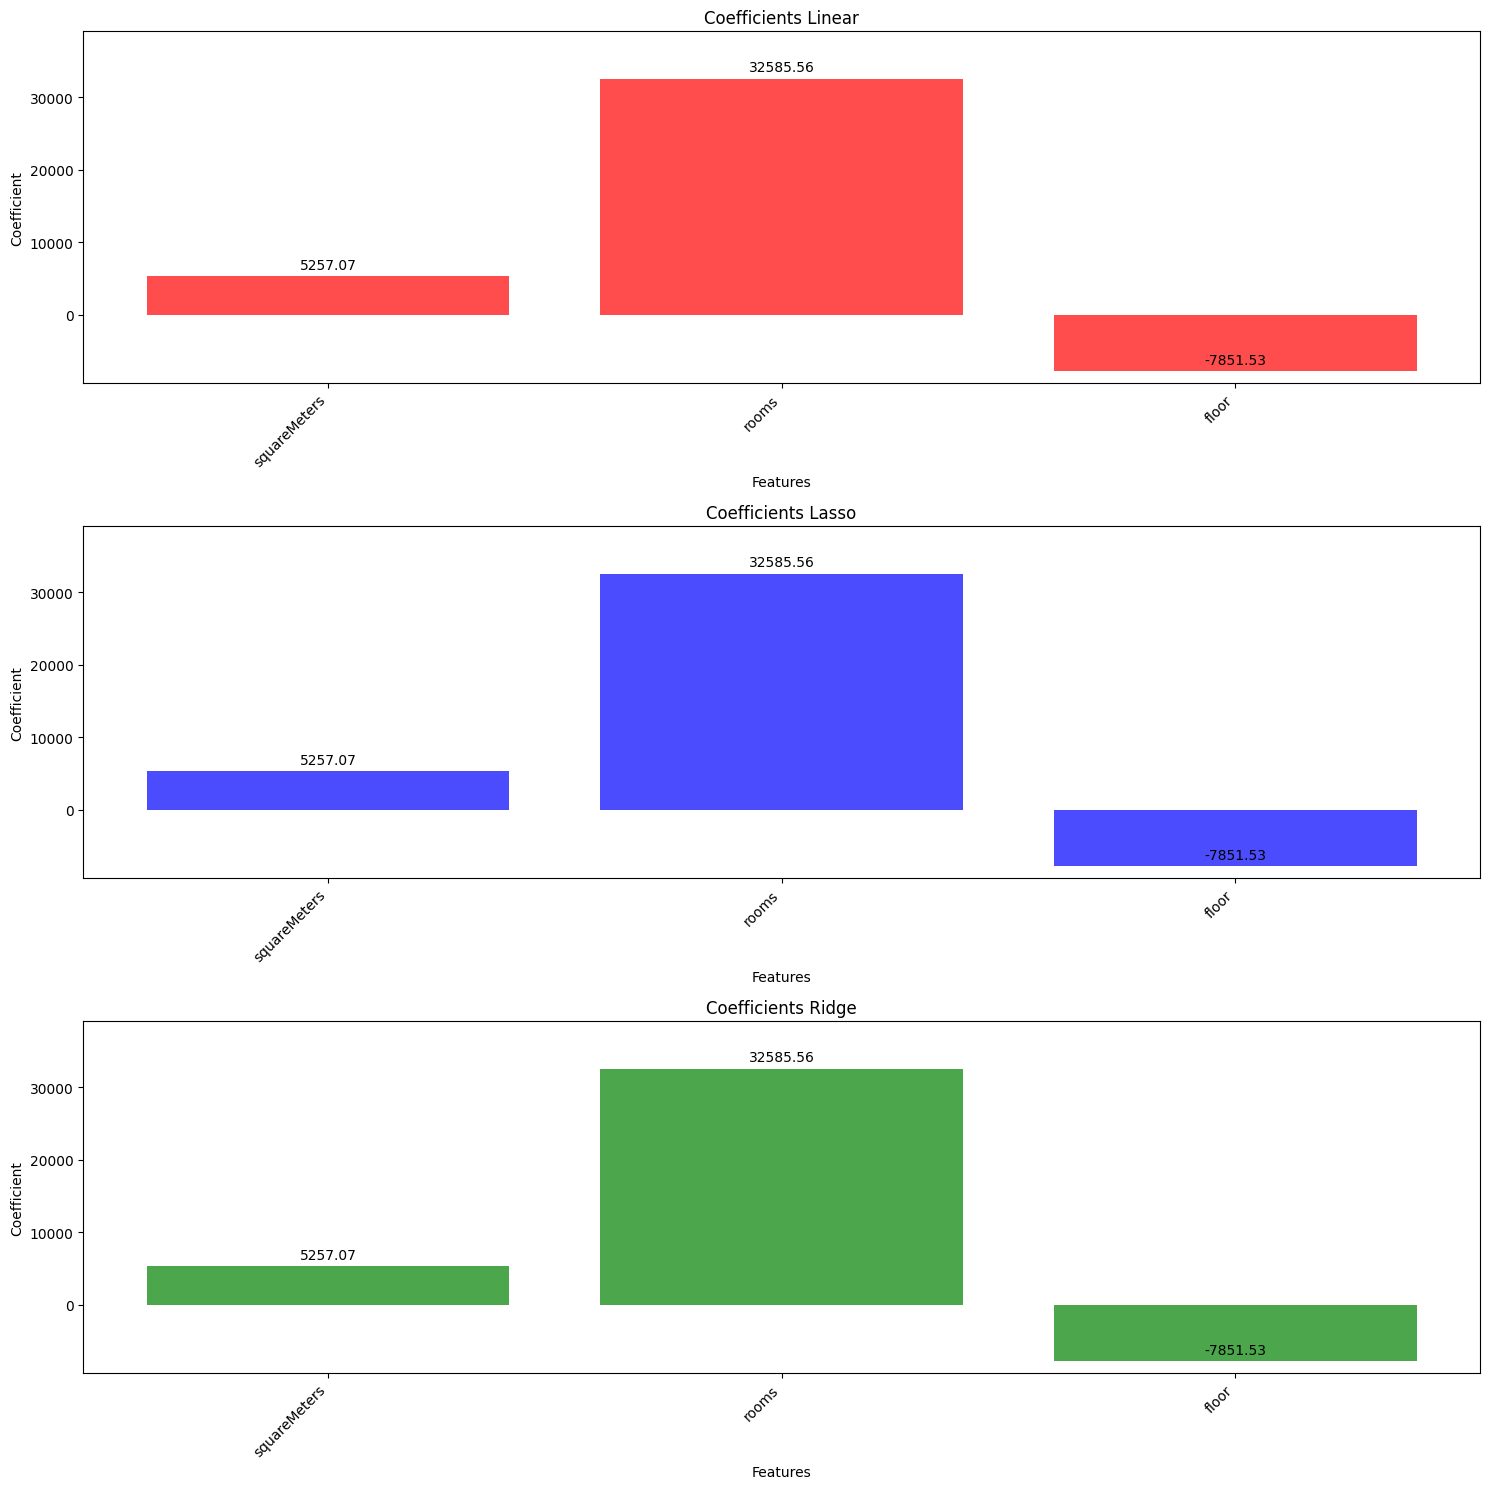

In [3]:
selected_model, selected_model_name, formula = find_best_regression_model(train_data[['squareMeters', 'rooms', 'floor']].head(1000), train_data['price'].head(1000))